In [1]:
import os
os.chdir('..')
import sys
home = os.path.expanduser('~')
caffe_dir = home + "/packages/py-faster-rcnn/caffe-fast-rcnn"
print(caffe_dir + '/python')
sys.path.insert(0, caffe_dir + '/python')

import caffe
import numpy as np
from pylab import *
%matplotlib inline

/home/ubuntu/packages/py-faster-rcnn/caffe-fast-rcnn/python


ImportError: libboost_system.so.1.55.0: cannot open shared object file: No such file or directory

In [ ]:
train_lmdb = caffe_dir + "/examples/cifar10/cifar10_train_lmdb"
test_lmdb = caffe_dir + "/examples/cifar10/cifar10_test_lmdb"

current_folder = home + "/projects/deep_learning/caffe"

prototext_train = current_folder + "/models/cifar_train.prototext"
prototext_test = current_folder + "/models/cifar_test.prototext"
prototext_solver = current_folder + "/models/cifar_solver.prototext"

In [2]:
cifar_10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [3]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.ip1 = L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    n.ip2 = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()

# Now, let's pass in the data path and create the files
with open(prototext_train, 'w+') as f:
    f.write(str(lenet(train_lmdb, 64)))
    
with open(prototext_test, 'w+') as f:
    f.write(str(lenet(test_lmdb, 100)))

ImportError: libboost_system.so.1.55.0: cannot open shared object file: No such file or directory

In [4]:
solver_text = """# The train/test net protocol buffer definition
train_net: "{train}"
test_net: "{test}"
test_net: "{train}"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 1
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
#snapshot: 5000
#snapshot_prefix: "examples/mnist/lenet" """.format(train=prototext_train, test=prototext_test)

with open(prototext_solver, 'w+') as f:
    f.write(solver_text)

NameError: name 'prototext_train' is not defined

In [6]:
with open(prototext_solver) as f:
    print(f.read())

# The train/test net protocol buffer definition
train_net: "/home/ubuntu/projects/deep_learning/caffe/models/cifar_train.prototext"
test_net: "/home/ubuntu/projects/deep_learning/caffe/models/cifar_test.prototext"
#bob_net: "/home/ubuntu/projects/deep_learning/caffe/models/cifar_train.prototext"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 1
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
#snapshot: 5000
#snapshot_prefix: "examples/mnist/lenet" 


In [7]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [8]:
try:
    if solver:
        del(solver)
except:
    pass
solver = caffe.SGDSolver(prototext_solver)

In [10]:
prototext_solver

'/home/ubuntu/projects/deep_learning/caffe/models/cifar_solver.prototext'

In [11]:
#%%bash -s "$caffe_dir" "$prototext_solver"
#cd $1/build/tools
#./caffe train --solver=$2

In [12]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 3, 32, 32)),
 ('label', (64,)),
 ('conv1', (64, 20, 28, 28)),
 ('pool1', (64, 20, 14, 14)),
 ('conv2', (64, 50, 10, 10)),
 ('pool2', (64, 50, 5, 5)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [13]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 3, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('ip1', (500, 1250)),
 ('ip2', (10, 500))]

In [14]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.3895440101623535, dtype=float32)}

blob dimensions: (64, 3, 32, 32)
label: automobile


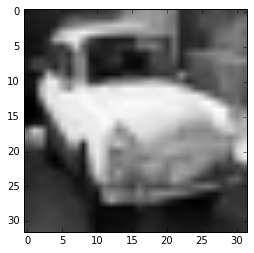

In [15]:
# Blob dimensions
print "blob dimensions:", solver.net.blobs['data'].data.shape

# Show first channel of first image
image = solver.net.blobs['data'].data[0,0]
imshow(image, cmap='gray')
# What is the label?
print "label:", cifar_10_labels[int(solver.net.blobs['label'].data[0])]

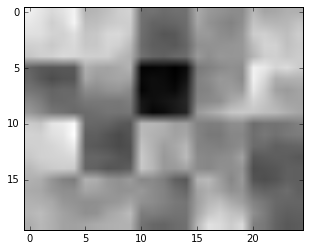

In [14]:
solver.step(1)
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

In [17]:
max_iters = 10000

test_interval = 20
# losses will also be stored in the log
#train_loss = zeros(max_iters)
#test_acc = zeros(int(np.ceil(max_iters / test_interval)))
#output = zeros((max_iters, 8, 10))
train_loss = []
test_acc = []

In [33]:
#%%time
niter = 400
# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    #print type(solver.net.blobs['loss'].data[()])
    train_loss.append(solver.net.blobs['loss'].data[()])
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    # solver.test_nets[0].forward(start='conv1')
    #output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        #print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc.append(correct / 1e4)
        for test_it in range(100):
            solver.net.blobs['data'].data = 

In [ ]:
solver.test_nets[0].fo

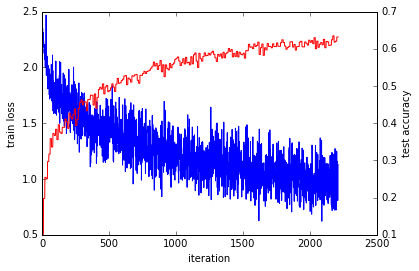

In [35]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(len(train_loss)), train_loss)
ax2.plot(arange(len(test_acc) * test_interval), [test_acc[x / test_interval] for x in range(len(test_acc) * test_interval)], 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')

In [39]:
solver.net.save(filename)

ArgumentError: Python argument types in
    Net.save(Net)
did not match C++ signature:
    save(caffe::Net<float>, std::string)

In [38]:
print hi

None


Things to try:
-Batch Normalization
-Dataset augmentation
-Residual architecture
-Different layer structure
-LOOK AT TRAINING ERROR TOO